In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

import os
import glob

In [2]:
from os import listdir
from os.path import isfile, join

dataset = pd.concat(map(pd.read_csv, glob.glob('/mnt/c/Users/aardp/Downloads/G3/*.csv')))
dataset.head()

,Year/Month,Box Size,Longitude,Latitude,PID2: Standard/Enhanced,Group,Checksum,S-S1,S-Median,S-S5,...,R-S1,R-Median,R-S5,R-Mean,R-Observation number,R-Standard deviation,R-Mean day of the month,R-Fraction of daylight observations,R-Mean Longitude,R-Mean Latitude
0,2010/1,2,18.0,74.0,0,3,13,0.27,0.65,1.03,...,60.4,62.3,62.9,61.7,3,1.9,30,0.0,0.6,0.0
1,2010/1,2,30.0,74.0,0,3,13,4.03,4.20,4.35,...,72.0,73.8,76.0,74.0,4,2.5,30,0.0,0.4,0.0
2,2010/1,2,18.0,72.0,0,3,6,4.17,5.50,6.20,...,61.0,72.6,80.4,71.9,21,9.3,28,0.0,0.7,0.5
3,2010/1,2,20.0,72.0,0,3,9,4.28,4.70,4.80,...,67.7,70.5,81.4,72.0,7,7.0,30,0.0,0.4,0.8
4,2010/1,2,22.0,72.0,0,3,0,4.14,4.45,4.81,...,61.5,65.7,71.2,66.3,4,6.4,30,0.0,0.5,0.8


In [3]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 270663 entries, 0 to 4466
Data columns (total 47 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   Year/Month                           270663 non-null  object 
 1   Box Size                             270663 non-null  int64  
 2   Longitude                            270663 non-null  float64
 3   Latitude                             270663 non-null  float64
 4   PID2: Standard/Enhanced              270663 non-null  int64  
 5   Group                                270663 non-null  int64  
 6   Checksum                             270663 non-null  int64  
 7   S-S1                                 270663 non-null  float64
 8   S-Median                             270663 non-null  float64
 9   S-S5                                 270663 non-null  float64
 10  S-Mean                               270663 non-null  float64
 11  S-Observation number

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [5]:
# Load the data
df = dataset

# Display the first few rows of the dataframe
print(df.head())

# Display information about the dataframe
print(df.info())

# Display statistical summary
print(df.describe())

# Check for any remaining NaN values
print(df.isna().sum())

# Remove rows with NaN values (if any)
df.dropna(inplace=True)

  Year/Month  Box Size  Longitude  Latitude  PID2: Standard/Enhanced  Group  \
0     2010/1         2       18.0      74.0                        0      3   
1     2010/1         2       30.0      74.0                        0      3   
2     2010/1         2       18.0      72.0                        0      3   
3     2010/1         2       20.0      72.0                        0      3   
4     2010/1         2       22.0      72.0                        0      3   

   Checksum  S-S1  S-Median  S-S5  ...  R-S1  R-Median  R-S5  R-Mean  \
0        13  0.27      0.65  1.03  ...  60.4      62.3  62.9    61.7   
1        13  4.03      4.20  4.35  ...  72.0      73.8  76.0    74.0   
2         6  4.17      5.50  6.20  ...  61.0      72.6  80.4    71.9   
3         9  4.28      4.70  4.80  ...  67.7      70.5  81.4    72.0   
4         0  4.14      4.45  4.81  ...  61.5      65.7  71.2    66.3   

   R-Observation number  R-Standard deviation  R-Mean day of the month  \
0                 

In [6]:
# Only run once on the same df

# Extract temporal features from 'Year/Month'
df['Year/Month'] = pd.to_datetime(df['Year/Month'], format='%Y/%m')
df['Year'] = df['Year/Month'].dt.year
df['Month'] = df['Year/Month'].dt.month

# Drop the original 'Year/Month' column, not strictly necessary
df.drop(columns=['Year/Month'], inplace=True)

In [7]:
# Split features and target
X = df[['Year', 'Month', 'Longitude', 'Latitude', 'S-Mean', 'A-Mean', 'Q-Mean', 'R-Mean']].values  # Features
y = df[['S-Mean']].values  # Targets

# Check for NaN or infinite values in targets
print("NaN values in y:", np.isnan(y).sum())
print("Infinite values in y:", np.isinf(y).sum())

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features using RobustScaler
scaler = RobustScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Check for NaN values in scaled features
print("NaN values in X_train:", np.isnan(X_train).sum())
print("NaN values in X_test:", np.isnan(X_test).sum())

print("Number of features:", X_train.shape[1])

NaN values in y: 0
Infinite values in y: 0
NaN values in X_train: 0
NaN values in X_test: 0
Number of features: 8


In [8]:
# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train, dtype=torch.float32).to(device)
y_test = torch.tensor(y_test, dtype=torch.float32).to(device)

# Create DataLoader
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size = 32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size = 32, shuffle=False)

# Define the model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(X_train.shape[1], 64)
        self.bn1 = nn.BatchNorm1d(64)
        self.fc2 = nn.Linear(64, 32)
        self.bn2 = nn.BatchNorm1d(32)
        self.fc3 = nn.Linear(32, y_train.shape[1])
        
    def forward(self, x):
        x = torch.relu(self.bn1(self.fc1(x)))
        x = torch.relu(self.bn2(self.fc2(x)))
        x = self.fc3(x)
        return x

model = NeuralNetwork().to(device)

In [9]:
# Define the optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr = 0.001)
criterion = nn.MSELoss()

# Training the model
num_epochs = 50
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    epoch_loss = running_loss / len(train_loader)
    train_losses.append(epoch_loss)
    
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item()
            
    val_loss /= len(test_loader)
    val_losses.append(val_loss)
    
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}")
    
# Evaluate the model
model.eval()
test_loss = 0.0
with torch.no_grad():
    for inputs, targets in test_loader:
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        test_loss += loss.item()
        
test_loss /= len(test_loader)
print(f"Test Loss: {test_loss:.4f}")

Epoch 1/50, Train Loss: 195.0643, Val Loss: 3.8101
Epoch 2/50, Train Loss: 3.0780, Val Loss: 0.3028
Epoch 3/50, Train Loss: 2.4121, Val Loss: 0.9400
Epoch 4/50, Train Loss: 2.1658, Val Loss: 0.3227
Epoch 5/50, Train Loss: 2.0371, Val Loss: 1.2556
Epoch 6/50, Train Loss: 1.8727, Val Loss: 0.2850
Epoch 7/50, Train Loss: 1.7524, Val Loss: 0.2880
Epoch 8/50, Train Loss: 1.6854, Val Loss: 0.3012
Epoch 9/50, Train Loss: 1.6135, Val Loss: 0.2863
Epoch 10/50, Train Loss: 1.5613, Val Loss: 0.6298
Epoch 11/50, Train Loss: 1.5229, Val Loss: 0.2632
Epoch 12/50, Train Loss: 1.4391, Val Loss: 0.4025
Epoch 13/50, Train Loss: 1.3637, Val Loss: 0.9163
Epoch 14/50, Train Loss: 1.3311, Val Loss: 0.3193
Epoch 15/50, Train Loss: 1.2929, Val Loss: 0.4644
Epoch 16/50, Train Loss: 1.2654, Val Loss: 0.2244
Epoch 17/50, Train Loss: 1.1987, Val Loss: 0.2118
Epoch 18/50, Train Loss: 1.1705, Val Loss: 0.5423
Epoch 19/50, Train Loss: 1.1493, Val Loss: 0.4724
Epoch 20/50, Train Loss: 1.0953, Val Loss: 0.5688
Epoch 2

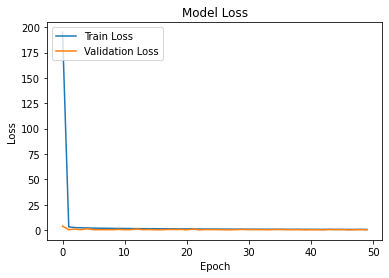

In [10]:
# Plot training & validation loss values
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

In [7]:
import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
from lightning.pytorch.loggers import TensorBoardLogger
import numpy as np
import pandas as pd
import torch

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import MAE, SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

TypeError: Cannot create a consistent method resolution
order (MRO) for bases Callback, PyTorchLightningPruningCallback